# The Peer Counseling Helpline Gmail Analysis
In this analysis, we'll investigate trends and analyse the behaviour of the Peer Counseling Helpline by examining the email activity of the VP of Scheduling and Communications. From this we can understand a little bit more about the helpline, how it runs, what works and what doesn't, how things have changed, and so on...

In [1]:
### import all the things ###
import mailbox
import string
import datetime
from dateutil.parser import parse
import random
import email.utils
import email
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.figure
import re
import seaborn as sns
from matplotlib.ticker import *
from collections import Counter
import nltk
from nltk.corpus import stopwords
import lxml.html
from nltk.stem import WordNetLemmatizer, PorterStemmer
import unicodedata
import gensim

### define all the things ###
def quarters(date):
# a function to print which quarter an email was in

    winter = [1,2,3] #january through march
    spring = [4,5,6] #april through june
    summer = [7,8] #july through september
    fall = [9,10,11,12] #october through december
    if date.month in winter:
        return "WN"
    elif date.month in spring:
        return "SPR"
    elif date.month in summer:
        return "SU"
    elif date.month in fall:
        return "FA"

def d_o_w(date):
#a function that returns the day on which a call was recorded
    
    days_of_week = {0:"Mon", 1:"Tues", 2:"Wed", 3:"Thurs", 4:"Fri", 5:"Sat", 6:"Sun"}
    temp = date.reset_index(drop=True)
    
    #subtract 12 hours as a buffer for late call logs throughout the night, since calls
    #can come in at up to 2 am, but call logs can be submitted at any time in the next day
    
    temp_day = temp["Date"] - pd.Timedelta(hours=12) 
    day = []
    for i in temp_day:
        day.append(days_of_week.get(i.dayofweek))
    return day

""" 
the following two functions are courtesy
of stack overflow user R. Fabbiri

http://stackoverflow.com/questions/7166922/extracting
-the-body-of-an-email-from-mbox-file-decoding-it-to
-plain-text-regard
"""
def getcharsets(msg):
    charsets = set({})
    for c in msg.get_charsets():
        if c is not None:
            charsets.update([c])
    return charsets

def getBody(msg):
    while msg.is_multipart():
        msg=msg.get_payload()[0]
    t=msg.get_payload(decode=True)
    for charset in getcharsets(msg):
        t=t.decode(charset)
    t = lxml.html.fromstring(t.lower()).text_content()
    t = unicodedata.normalize("NFKD", t)
    t = re.sub(r'[\t\n\r]', ' ', t)
    return t


//anaconda/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


## The Data Set

In [2]:
full_mail = mailbox.mbox("PCHGmail.mbox")
print(type(full_mail))
print(full_mail[0].keys())
print("This mailbox has " + str(len(full_mail)) + " messages.")

<class 'mailbox.mbox'>
['X-GM-THRID', 'X-Gmail-Labels', 'MIME-Version', 'Received', 'Date', 'Delivered-To', 'Message-ID', 'Subject', 'From', 'To', 'Content-Type']
This mailbox has 2991 messages.


This is a decent number of messsages, so hopefully we will get some good data out of it. Let's see what kind of object mbox creates and how we can manipulate it. Each message is a mini dictionary of key-value pairs, including dates, delivery reports, subjects, and the to- and from- fields. Knowing this, we can use Pythonic dictionary and list comprehension to go through the analysis.

In [3]:
n = random.randrange(0, len(full_mail))
print("AN EXAMPLE OF THE SUBJECT: " + full_mail[n]["Subject"])
print("\nAN EXAMPLE OF THE SENDER: " + full_mail[n]["From"])
print("\nAN EXAMPLE OF THE RECEPIENTS: " + full_mail[n]["To"])
print("\nAN EXAMPLE OF THE BODY: " + str(full_mail[n].get_payload()[0]))

AN EXAMPLE OF THE SUBJECT: Meeting Minutes 11-17-10

AN EXAMPLE OF THE SENDER: Peer Counseling <drexelpeercounseling@gmail.com>

AN EXAMPLE OF THE RECEPIENTS: Aaron Bloch <asb69@drexel.edu>, Amy Henning <henninaj@drexel.edu>, 
	Armand Pinckney <aup24@drexel.edu>, Brittany Cumens <bc432@drexel.edu>, 
	Christina Verzijl <clv27@drexel.edu>, Crystal Jicha <cjj34@drexel.edu>, Emily Glassman <eag57@drexel.edu>, 
	Hayley Tintie <hat27@drexel.edu>, Hilary Lichten <hl365@drexel.edu>, 
	Libby Lambert <Libby.Lambert@gmail.com>, Lindsay Haston <lh388@drexel.edu>, 
	Megan Hartz <meh86@drexel.edu>, Mike Hoffman <mjh98@drexel.edu>, Nicole Phillips <np382@drexel.edu>, 
	Peer Counseling <drexelpeercounseling@gmail.com>, Ranna Jaraha <rjaraha@gmail.com>, 
	Sima Patel <sap86@drexel.edu>, Sofia Tamimi <set49@drexel.edu>, 
	Stephanie Goldstein <spgoldstein38@gmail.com>, Taylor Nolan <tln26@drexel.edu>, 
	Tess <tessmorgan16@yahoo.com>, Theodore Chung <tc92@drexel.edu>, 
	Thomas Aurney <tph27@drexel.edu>, Wi

Cool. We'll get back to the bodies later. To start, let's get it into a workable data frame:

In [4]:
fields = ['Date', 'From', 'To', 'Subject','X-Gmail-Labels', 'X-GM-THRID' ]
allMessages = []
for message in full_mail.itervalues():
    dmessage = dict(message.items())
    allMessages.append({field:dmessage[field] if field in dmessage.keys() else '' for field in fields})

mail = pd.DataFrame(allMessages)
mail['Date'] = pd.to_datetime(mail['Date'], utc=True)
mail["Quarter"]=[quarters(i) for i in mail["Date"]]
mail.head()

,Date,From,Subject,To,X-GM-THRID,X-Gmail-Labels,Quarter
0,2010-11-18 15:30:29,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 11-17-10,"Aaron Bloch <asb69@drexel.edu>, Amy Henning <h...",1352761846615791799,"Sent,Old terms",FA
1,NaT,rachkoya@gmail.com,,drexelpeercounseling@gmail.com,1267149499080961097,Chat,None
2,NaT,drexelpeercounseling@gmail.com,,rachkoya@gmail.com,1267149499080961097,Chat,None
3,2009-06-05 14:31:55,"""Henning,Amy"" <henninaj@drexel.edu>",RE: Call Re-Count,Peer Counseling <drexelpeercounseling@gmail.com>,1304651164807056933,Old Calls,SPR
4,2009-06-08 02:41:48,Veronica Barndt <vb392@drexel.edu>,Call Log,Amy Henning <henninaj@drexel.edu>,1304878287771506005,Old Calls,SPR


We can get a list of all the counselors who have been working the helpline with a little bit of text processing.

In [5]:
#names = [full_mail[i]["To"].split(",") for i in range(len(full_mail))]
workingNames=[]
for i in range(len(full_mail)):
    if full_mail[i]["To"]:
        current = full_mail[i]["To"].split(",")
        for j in current:
            workingNames.append(j)
            
#print(workingNames)

allnames = []
for j in range(len(workingNames)):
    if workingNames[j].partition("<"):
        t = workingNames[j].partition("<")[0]
        t = re.sub(r'[\t\n\r]', '', t).strip()
        if not "." in t:
            allnames.append(t.replace("\"","").replace("\'", ""))

for i in allnames:
    if i.split() != i:
        del i

print("Here are " + str(len(set(allnames))) + 
      " people who've been affiliated with the helpline!\n\n"+
      str(set(allnames)))

Here are 204 people who've been affiliated with the helpline!

{'Peer Counseling', '', 'Adreeja GuhaRay', 'Alyssa Quintana', 'Audrey Jones', 'Stephanie Goldstein', 'Karen Grundy', 'Charlotte Matri', 'Jessica Christie', 'Rachel', 'Karmpreet Kaur', 'Francesca Torno', 'Liana Miley', 'Nicholas Kilkenny', 'Haley Simon', 'Erin Giles', 'Siara Johnson', 'Natasha Metzger', 'Lauren DiMatteo', 'Nick Kilkenny', 'Sokoloski', 'Jillian Neill', 'Tarika Aggarwal', 'Colleen Keys', 'Michelle', 'Amy Henning', 'Alexis Brauz', 'Ben', 'Stephanie Malamas', 'Amy Shah', 'Elise Rosanio', 'Lindsey Dever', 'Khushbu Patel', 'Marisa Mastropasqua', 'Aaron Bloch', 'Kert Heinecke', 'Hayley Tintle', 'Alexandra Pyne', 'Emily Ranieri', 'Madison Macintosh', 'DePrisco', 'Meghan Angelos', 'Sabina Custovic', 'Sarah Delgrosso', 'Sofia Tamimi', 'Kelly OHara', 'Lily Pliskin', 'Danielle Jordan', 'Scott Sokoloski', 'Abigail Nash', 'William Lukas', 'Lindsay Haston', 'crystal jicha', 'Thomas Aurney', 'Ricki Miglin', 'Amy', 'Beverly 

I'd say it's closer to 150 since we were a little bit sloppy with finding individual name permutations, and a couple of errors got through too.
# Email Traffic
Let's take a look at what the email traffic has been like for this email account (1) overall (2) per quarter?

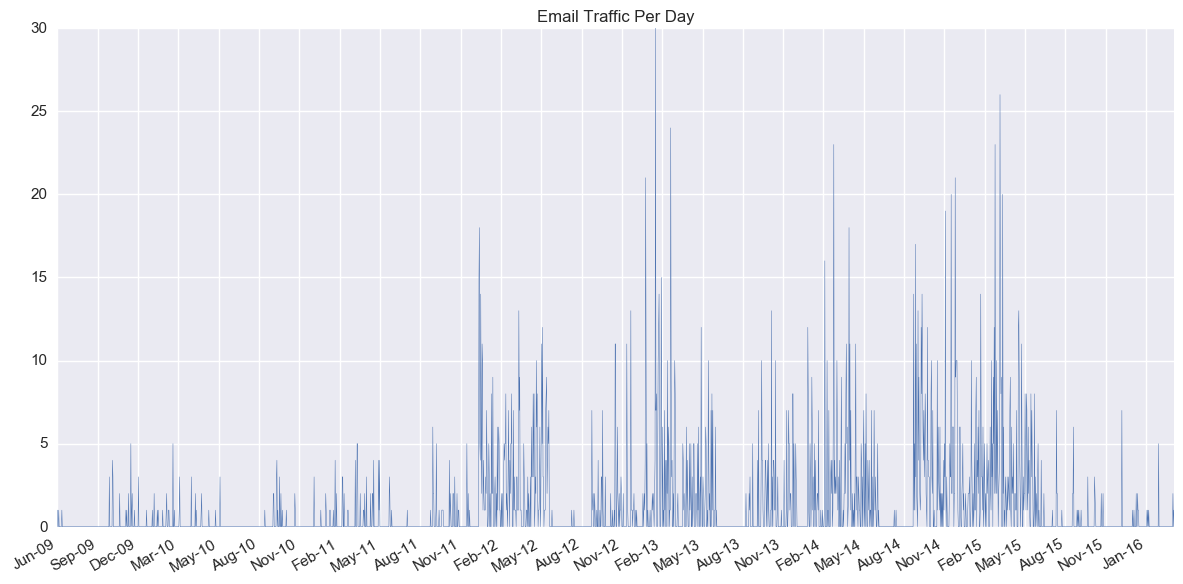

In [6]:
#a couple of null dates need to be removed first
mail = mail[mail["Date"].notnull() == True]           
mail = mail.reset_index(drop = True)

#get the traffic per day
dates = pd.Series([x.date() for x in mail['Date']])
df = dates.value_counts().sort_index()
date_range = pd.date_range(start=min(dates), end=max(dates), freq='D')
df = pd.Series(df.reindex(date_range,fill_value=0), name="Emails")

#plot
fig = plt.figure()
df.plot(figsize=(12,6), title='Email Traffic Per Day', linewidth=0.35, fontsize = 11)
start, end = plt.gca().get_xlim()
step = 90
labels = df[::step].index.strftime('%b-%y') 
plt.xticks(range(int(start), int(end), step), labels, rotation=45, ha="right")
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()
fig.savefig('trafficPerDay.png')

From this plot we can see that some days had up to 30 emails sent in one conversation; it's likely that these are days when we have calls or when we have a lot of administrative work to do. We can also see that the usage of this email address was probably greatest in the 2012/2013 year, but the following two years have decreased usage. It might demonstrate the change in administrative style of each board.

Let's see which quarter has the most activity.

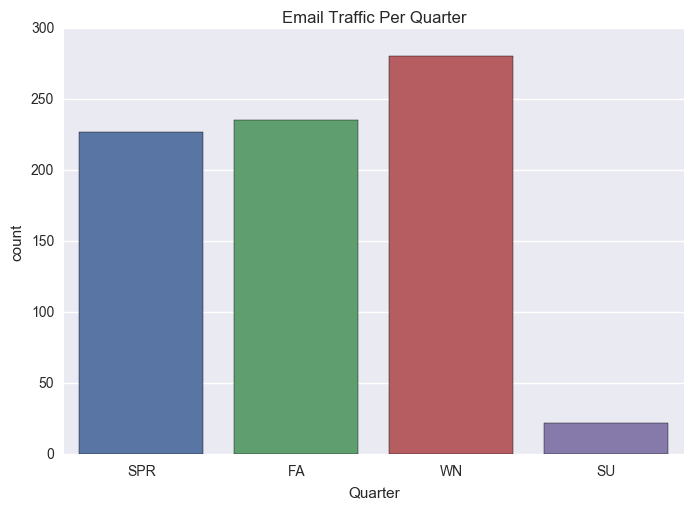

In [7]:
#count the emails per quarter
dates = pd.Series([x.date() for x in mail['Date']])
df = dates.value_counts().sort_index()
df=df.reset_index().rename(columns={"index":"Date",0:"Count"})
x,y=df["Date"],df["Count"]
q = [quarters(i) for i in x]

#plot
fig = plt.figure()
sns.countplot(data=pd.DataFrame(dict(Date=x,Count=y, Quarter=q)), x="Quarter")
sns.plt.title("Email Traffic Per Quarter")
sns.plt.show()
fig.savefig('trafficPerQTR.png')

Of course, summer term has the least activity (mostly admin), but it looks like winter term has the most, followed by fall. This might suggest that winter term either has the most call conversation, or might require the most work on the part of the board (or both).

# Call Metrics

Let's try and analyze the call metrics.

In [8]:
#count the calls according to the subject, and remove the ones
#that are replies, or practice/examples from training VPs

mail = mail.rename(columns = {"X-GM-THRID" : "Thread","X-Gmail-Labels" : "Labels"})
calls = mail[mail["Subject"].str.contains("Call|CALL|call", regex = True)]
calls = calls[calls["Subject"].str.contains("Re:|RE:|Fwd:|Practice|Example", regex=True) == False]
calls.head()

,Date,From,Subject,To,Thread,Labels,Quarter
2,2009-06-08 02:41:48,Veronica Barndt <vb392@drexel.edu>,Call Log,Amy Henning <henninaj@drexel.edu>,1304878287771506005,Old Calls,SPR
3,2009-09-29 01:46:03,Meghan Angelos <mma42@drexel.edu>,CALL,Peer Counseling <drexelpeercounseling@gmail.com>,1315112237970624914,Old Calls,FA
6,2009-10-06 01:01:06,Nadia Fernand <ndfernand124@gmail.com>,CALL!,Peer Counseling <drexelpeercounseling@gmail.com>,1315743587806917891,Old Calls,FA
10,2009-10-07 02:35:32,Nadia Fernand <ndfernand124@gmail.com>,PCH CALL,Peer Counseling <drexelpeercounseling@gmail.com>,1315840126535438518,Old Calls,FA
13,2009-10-22 02:43:52,Crystal Jicha <cjj34@drexel.edu>,Call tonight,"jac424@drexel.edu, jcd42@drexel.edu, als96@dre...",1317199605992273464,Old Calls,FA


In [9]:
print("We've had approximately " + str(len(calls)) + " calls on the helpline.")
print("That's approximately " + str(int(len(calls)/18)) + 
      " calls per term from Fall 2009 to Spring 2015, or " 
      + str(round(len(calls)/180,2)) + " calls per week.")

We've had approximately 207 calls on the helpline.
That's approximately 11 calls per term from Fall 2009 to Spring 2015, or 1.15 calls per week.


This is assuming that what constitutes a call is (1) not a practice or example call from training, (2) is an emailed call log from a counselor who's subject contains the word "Call", and (3) is not a reply.

This confirms our assumption that we've been getting about 1 call a week.

We can break down the number of calls further.

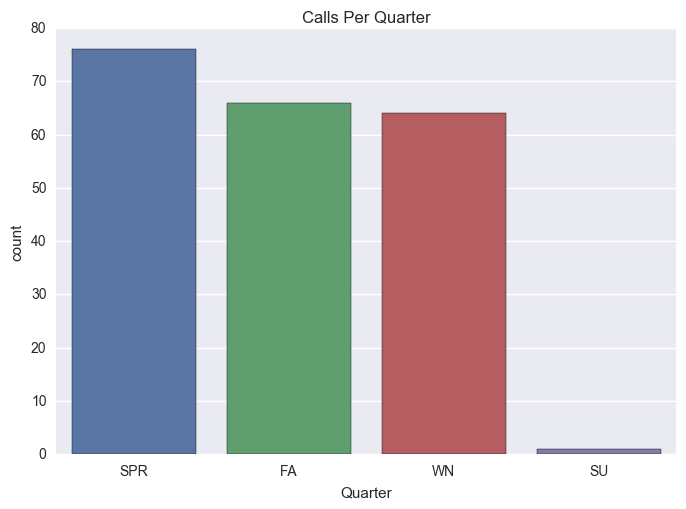

In [10]:
#make a binary vector of calls and plot

c = mail.index.tolist()
for i in c:
    if i in calls.index:
        c[i] = 1
    else:
        c[i] = 0

mail["Call"] = c

df = mail.loc[mail['Call'] == 1]

#plot
fig = plt.figure()
sns.countplot(data=df, x="Quarter")
sns.plt.title("Calls Per Quarter")
sns.plt.show()
fig.savefig("callsPerQTR.png")

So it looks like the spring term is our busiest in terms of calls. This supports what we are told in our training (research suggests that spring time is a high-risk time of year in the US for suicide and depression).

Now that we know the calls per term, let's take a closer look at which days have the most calls.

//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


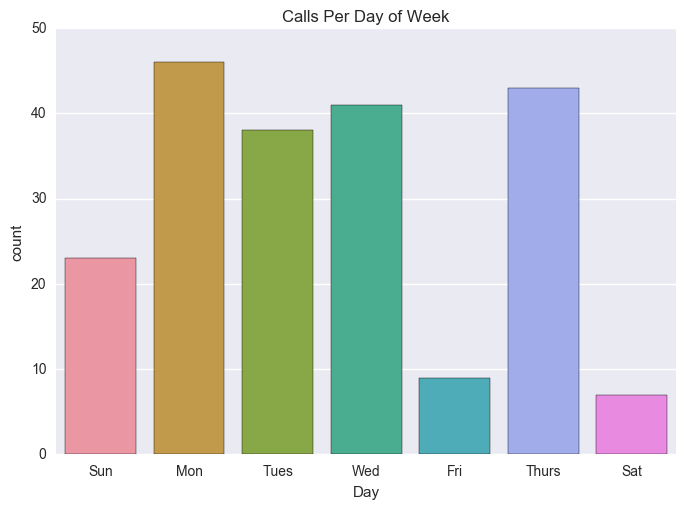

In [11]:
#get a day column
Day = d_o_w(df)
df["Day"] = Day

#plot
fig = plt.figure()
sns.countplot(data=df, x="Day")
sns.plt.title("Calls Per Day of Week")
sns.plt.show()
fig.savefig("callsPerDay.png")

We can attribute the Friday and Saturday call counts to the inaccuracy of the subsetting and the fact that sometimes call logs are sent late (although we implemented a 12 hour buffer).

So from this plot, it seems as though Monday nights are the most popular for calls, followed by Thursday and Wednesday. Surprisingly, Sunday was the least. One would expect weekends to have more traffic than weekdays, but that is clearly not the case. Of course, this must be taken with some level of inaccuracy due to the use of the 12 hour buffer and the timing of call log receipts.

# Active Counselor Count

Next, let's find out what the frequency of active counselors has looked like over time. To do this, we can assume that all the active counselors on the helpline are included in a "meeting minutes" email.

In [12]:
#using regular expressions to get the meeting minutes emails
minutes = mail[mail["Subject"].str.contains("Minutes", regex = True)]
minutes = minutes[minutes["Subject"].str.contains("Re:|RE:|Fwd:", regex=True) == False]
minutes = minutes.reset_index(drop=True)
minutes.head()

,Date,From,Subject,To,Thread,Labels,Quarter,Call
0,2010-11-18 15:30:29,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 11-17-10,"Aaron Bloch <asb69@drexel.edu>, Amy Henning <h...",1352761846615791799,"Sent,Old terms",FA,0
1,2009-11-24 21:43:25,Peer Counseling <drexelpeercounseling@gmail.com>,Staff Meeting Minutes,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1320260998675529196,Sent,FA,0
2,2010-01-16 20:47:15,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 1-14-10,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1325059104003714772,Sent,WN,0
3,2010-02-21 20:30:43,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 2-18-10,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1328319555550870786,Sent,WN,0
4,2010-03-04 04:48:13,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 3-3-10,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1329256824877506661,Sent,WN,0


In [13]:
counselors = [len(minutes["To"][i].split(",")) for i in range(len(minutes["To"]))]
minutes["Counselors"] = counselors
minutes.head()

,Date,From,Subject,To,Thread,Labels,Quarter,Call,Counselors
0,2010-11-18 15:30:29,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 11-17-10,"Aaron Bloch <asb69@drexel.edu>, Amy Henning <h...",1352761846615791799,"Sent,Old terms",FA,0,24
1,2009-11-24 21:43:25,Peer Counseling <drexelpeercounseling@gmail.com>,Staff Meeting Minutes,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1320260998675529196,Sent,FA,0,22
2,2010-01-16 20:47:15,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 1-14-10,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1325059104003714772,Sent,WN,0,20
3,2010-02-21 20:30:43,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 2-18-10,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1328319555550870786,Sent,WN,0,20
4,2010-03-04 04:48:13,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 3-3-10,"mma42@drexel.edu, pra29@drexel.edu, vab32@drex...",1329256824877506661,Sent,WN,0,20


In [14]:
df=minutes.set_index(minutes["Date"], drop=True).sort_index()
df["Counselors"].describe()

count    69.000000
mean     23.681159
std       8.777466
min       1.000000
25%      22.000000
50%      24.000000
75%      30.000000
max      38.000000
Name: Counselors, dtype: float64

In [15]:
#there are a couple of 1's; not possible
df.loc[df['Counselors'] == 1]

,Date,From,Subject,To,Thread,Labels,Quarter,Call,Counselors
Date,,,,,,,,,
2011-03-03 03:25:17,2011-03-03 03:25:17,Stephanie Goldstein <spgoldstein38@gmail.com>,Meeting Minutes 3/2/2011,Petra Artz <prartz@gmail.com>,1362228902708195612,Old terms,WN,0,1
2012-05-12 01:13:30,2012-05-12 01:13:30,Megan Hartz <meganehartz@gmail.com>,Meeting Minutes 5/9/2012,Peer Counseling <drexelpeercounseling@gmail.com>,1401720888446815182,Old terms,SPR,0,1
2014-09-26 15:36:47,2014-09-26 15:36:47,Mia Smith <mls388@drexel.edu>,9/25/14 Training Minutes,Peer Counseling <drexelpeercounseling@gmail.com>,1480322772462460681,"Training,Important",FA,0,1
2014-10-10 00:46:21,2014-10-10 00:46:21,"""Nicholas Kilkenny"" <njk42@drexel.edu>",Meeting Minutes,"""Peer Counseling"" <drexelpeercounseling@gmail....",1481535108906785446,"Important,Meeting Minutes",FA,0,1
2015-03-02 04:29:37,2015-03-02 04:29:37,Mia Smith <mls388@drexel.edu>,Meeting Training Minutes: Validations!,Peer Counseling <drexelpeercounseling@gmail.com>,1494504521521259588,"Training,Important",WN,0,1
2015-07-14 22:43:14,2015-07-14 22:43:14,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes Template,Peer Counseling <drexelpeercounseling@gmail.com>,1506713319485234990,"Important,Templates/Position Responsibilities,...",SU,0,1


In [16]:
#remove them
df.loc[df['Counselors'] == 1]
df = df[df.Counselors != 1]
df["Counselors"].describe()

count    63.000000
mean     25.841270
std       5.474888
min       8.000000
25%      23.000000
50%      25.000000
75%      30.000000
max      38.000000
Name: Counselors, dtype: float64

In [17]:
#and an 8; must also be an error
df.loc[df['Counselors'] == 8]

,Date,From,Subject,To,Thread,Labels,Quarter,Call,Counselors
Date,,,,,,,,,
2015-04-01 01:10:53,2015-04-01 01:10:53,Peer Counseling <drexelpeercounseling@gmail.com>,PCH Board Meeting Minutes (3/31/15),"Erin Sue Giles <erinsuegiles@gmail.com>, Jessi...",1497209927127422659,"Important,Meeting Minutes,Sent",SPR,0,8


In [18]:
#remove
df = df[df.Counselors != 8]
df["Counselors"].describe()

count    62.000000
mean     26.129032
std       5.016314
min      16.000000
25%      23.000000
50%      25.000000
75%      30.000000
max      38.000000
Name: Counselors, dtype: float64

In [19]:
df.loc[df['Counselors'] == 38]
#probably relevant

,Date,From,Subject,To,Thread,Labels,Quarter,Call,Counselors
Date,,,,,,,,,
2012-05-24 02:48:52,2012-05-24 02:48:52,Peer Counseling <drexelpeercounseling@gmail.com>,Meeting Minutes 5/23/12,"Aaron Bloch <abloch11@gmail.com>, Abigail Nash...",1402814052544356963,"Sent,Old terms",SPR,0,38


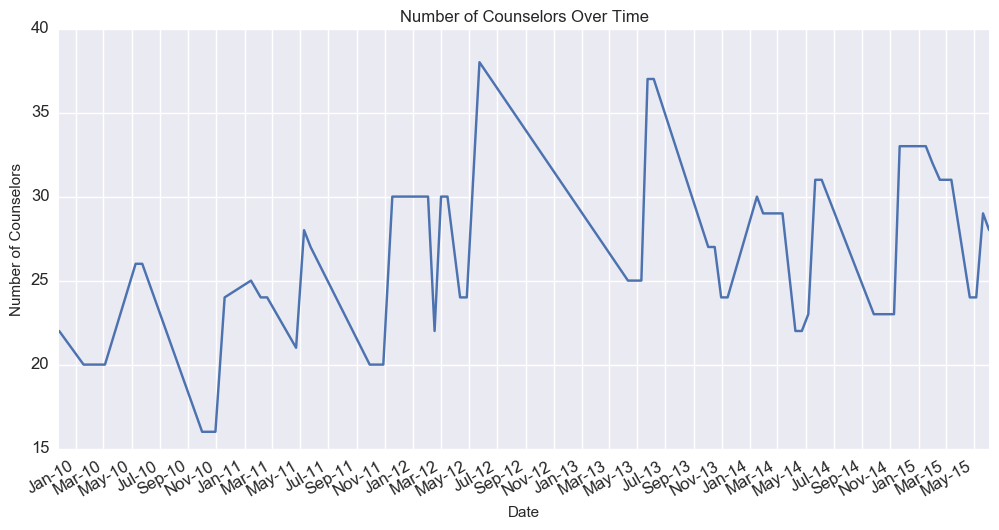

In [20]:
#plot
fig = plt.figure()
df["Counselors"].plot(figsize=(12,6), title='Number of Counselors Over Time', fontsize = 12)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b-%y"))
plt.gcf().autofmt_xdate()
plt.gca().set_ylabel("Number of Counselors")
plt.show()
fig.savefig("counselorsTime.png")

While this is not the *most* accurate method of getting this data, we can still see some useful trends. For example, the median number of counselors has probably increased since 2010.

Let's check the summary statistics of this subset of data.

In [21]:
print("Some statistics about our active counselors:\n\n")
print(df["Counselors"].describe())

Some statistics about our active counselors:


count    62.000000
mean     26.129032
std       5.016314
min      16.000000
25%      23.000000
50%      25.000000
75%      30.000000
max      38.000000
Name: Counselors, dtype: float64


Our the median number of active counselors per term is 25 (we use the median since we can't have .129 of a counselor). With a minimum of 16 and a maximum of 38, I can see how this would be a safe range. Let's visualise this finding.

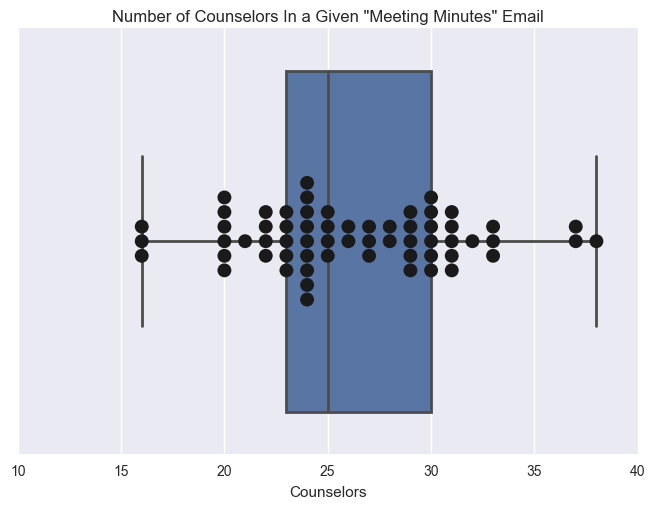

In [22]:
#plot
fig = plt.figure()
sns.boxplot(data=df, x="Counselors", linewidth=2)
sns.swarmplot(data=df, x="Counselors", color="0.1", size = 10)
sns.plt.title("Number of Counselors In a Given \"Meeting Minutes\" Email")
sns.plt.show()
fig.savefig("numCounselors.png")

This plot is a little complex, but here's the rundown:

This is a numberline overlayed on a boxplot. Each dot represents a meeting minutes email, with the number of counselors in that email on the *X*-axis. Each vertical line in a boxplot shows a statistical feature of this slice of data (from left to right: the minimum, 1st quartile, median, 3rd quartile, and maximum).

So from this plot, we can see that the median number of active counselors we can expect is 25. We can also see that the minimum is 16, and the maximum is 38, and the majority of counts (the interquartile range) is between 23 and 30.

We can subset this plot by quarter to see in further detail:

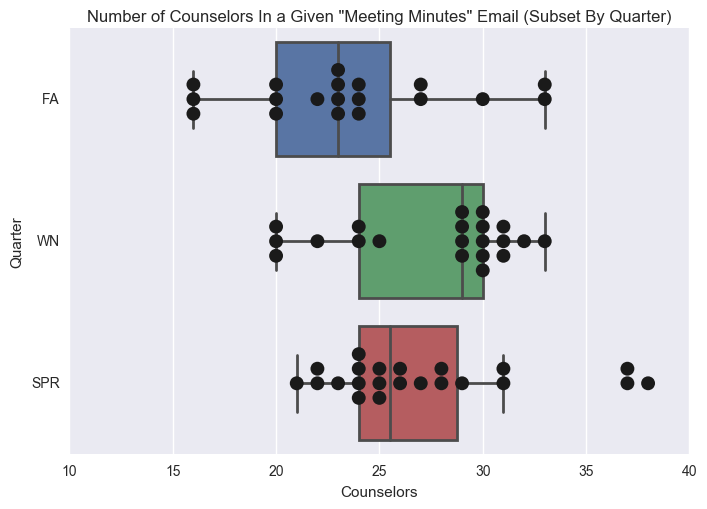

In [23]:
#plot
fig = plt.figure()
sns.boxplot(data=df, y="Quarter", x="Counselors", linewidth=2)
sns.swarmplot(data=df, y="Quarter", x="Counselors", color="0.1", size = 10)
sns.plt.title("Number of Counselors In a Given \"Meeting Minutes\" Email (Subset By Quarter)")
sns.plt.show()
fig.savefig("numCounselorsQTR.png")

Here's what we can gather from this plot:
+ The highest number of counselors was 38, followed by 37, both in a Spring term. These are statistical outliers, so very unlike the other other instances in this term. Our sample size is small, since we haven't absolutely accurately included all the meeting minute emails; however, it just may be that we had a term with 38 counselors.
+ The Fall term has the lowest number of counselors; we can see this from the absolute lowest number (16), and we can see that the median (line in the middle of the box) is lower than the other terms' medians (Fall = 23, Winter = 29, Spring = 25.5).
+ The winter term has the highest median number of active counselors. This is somewhat reflected by the fact that it is also the busiest term for emails.
+ The spring term has the most stable number of counselors, discounting the outlier points. The number of counselors in this term is in a very tight interquartile and overall range.

Interestingly, the 37/38 count of counselors is no outlier to the overall dataset, but an outlier in the spring. Let's check when that was:

In [24]:
print(df.loc[df['Counselors'] == 37].iloc[0])
thirtySeven1 = str(df.loc[df['Counselors'] == 37]["Thread"].iloc[0])
thirtySeven1 = full_mail['X-GM-THRID' == thirtySeven1]
print(thirtySeven1.get_payload()[0])

Date                                        2013-05-23 12:39:35
From           Peer Counseling <drexelpeercounseling@gmail.com>
Subject                               Meeting Minutes 5/22/2013
To            Aaron Bloch <abloch11@gmail.com>, Abigail Nash...
Thread                                      1435828512875095869
Labels                                           Sent,Old terms
Quarter                                                     SPR
Call                                                          0
Counselors                                                   37
Name: 2013-05-23 12:39:35, dtype: object
Content-Type: text/plain; charset=ISO-8859-1

Hello counselors

Thank you all who attended the meeting this Wednesday. It was a good first
meeting with all of the new counselors.

We started with a few reminders about the helpline. Please remember to call
once you and your partner reach the shift. Also, make sure to check the
schedule thoroughly for your shifts. There is not much 

In [25]:
print(df.loc[df['Counselors'] == 37].iloc[1])
thirtySeven1 = str(df.loc[df['Counselors'] == 37]["Thread"].iloc[1])
thirtySeven1 = full_mail['X-GM-THRID' == thirtySeven1]
print(thirtySeven1.get_payload()[0])

Date                                        2013-06-05 22:44:55
From           Peer Counseling <drexelpeercounseling@gmail.com>
Subject              Meeting Minutes 6/5/2013 Last of the year!
To            Aaron Bloch <abloch11@gmail.com>, Abigail Nash...
Thread                                      1437044358047696334
Labels                                           Sent,Old terms
Quarter                                                     SPR
Call                                                          0
Counselors                                                   37
Name: 2013-06-05 22:44:55, dtype: object
Content-Type: text/plain; charset=ISO-8859-1

Hello counselors

Thank you all who attended the meeting this Wednesday. It was a good first
meeting with all of the new counselors.

We started with a few reminders about the helpline. Please remember to call
once you and your partner reach the shift. Also, make sure to check the
schedule thoroughly for your shifts. There is not much 

In [26]:
print(df.loc[df['Counselors'] == 38])
thirtyEight = str(df.loc[df['Counselors'] == 38]["Thread"])
thirtyEight = full_mail['X-GM-THRID' == thirtyEight]
print(thirtyEight.get_payload()[0])

                                   Date  \
Date                                      
2012-05-24 02:48:52 2012-05-24 02:48:52   

                                                                 From  \
Date                                                                    
2012-05-24 02:48:52  Peer Counseling <drexelpeercounseling@gmail.com>   

                                     Subject  \
Date                                           
2012-05-24 02:48:52  Meeting Minutes 5/23/12   

                                                                    To  \
Date                                                                     
2012-05-24 02:48:52  Aaron Bloch <abloch11@gmail.com>, Abigail Nash...   

                                  Thread          Labels Quarter  Call  \
Date                                                                     
2012-05-24 02:48:52  1402814052544356963  Sent,Old terms     SPR     0   

                     Counselors  
Date                     

It looks like each of these are independant threads, but contain the same content, which might explain why they are statistical outliers all hanging out together on one end of the distribution. Not only that, but they have different dates too.

However, we can't discount this occurrence because in the message content we notice that it was right after inducting new counselors. So while counting 38 3 times may skew the distribution, 38 was not a wrong observation.

# Text Analysis of Email Bodies

Now the fun bit: we can analyse the bodies of call logs to get an idea of what our calls have been about.

In [27]:
# process each email and get the body;
# if not, report, and append an empty string
bodies = []
for i in range(len(full_mail)):
    try:
        t = getBody(full_mail[i])
        #t = lxml.html.fromstring(t.lower()).text_content()
        #t = unicodedata.normalize("NFKD", t)
        bodies.append(t)
    except:
        bodies.append("")
# remove pesky replies and signatures
bodies = [re.sub("on \d\d/\d\d/\d\d.+","",bodies[n]) for n in range(len(bodies))]
bodies = [re.sub("--.+","",bodies[n]) for n in range(len(bodies))]
bodies = [re.sub("_+", "",bodies[n]) for n in range(len(bodies))]

In [28]:
# make a data frame as before and add the body
mail = pd.DataFrame(allMessages)
mail['Date'] = pd.to_datetime(mail['Date'], utc=True)
mail["Quarter"]=[quarters(i) for i in mail["Date"]]
mail["Body"] = bodies

# a couple of null dates need to be removed first
mail = mail[mail["Date"].notnull() == True]
mail = mail.reset_index("Date").sort_index()
mail = mail.rename(columns = {"X-GM-THRID" : "Thread","X-Gmail-Labels" : "Labels"})

# we don't need everything, just keep the important
# columns and subset the calls as before
mail = mail[["Quarter", "Subject", "Body", "Date"]]
calls = mail[mail["Subject"].str.contains("Call|CALL|call", regex = True)]
calls = calls[calls["Subject"].str.contains("Re:|RE:|Fwd:|Practice|Example", regex=True) == False].reset_index(drop=True)
calls.head()

,Quarter,Subject,Body,Date
0,SPR,Call Log,"hi amy, i counted up all of the recorded call...",2009-06-08 02:41:48
1,FA,CALL,at 8:45 nadia and i got a call from a female c...,2009-09-29 01:46:03
2,FA,CALL!,"hey everyone, so tonight meghan and i recei...",2009-10-06 01:01:06
3,FA,PCH CALL,"hello everyone, had another caller tonight, m...",2009-10-07 02:35:32
4,FA,Call tonight,so stef and i got a call tonight at 10 that la...,2009-10-22 02:43:52


# Call Times

While we encourage counselors to send call logs immediately after they receive a call, sometimes there can be delays, and even when we get a call log, the call itself may have only started an hour prior. What we can do is try to extract what time people call by analysing the call logs for any time-like text.

In [29]:
callTimes = []
callDurations = []

for n in range(len(calls)):
    try:
        current = calls["Body"][n]

        TWOHOURS = parse("2hours")-parse("0minutes")

        # ----FINDING A CALL START/END TIME------#
        #find anything that looks like time hh:mm
        times = re.findall(r'\d{1,2}[:|;]\s*\d\d\w{0,2}', current)
        #print(times)
        #if found, parse it using parser
        if len(times):
            for t in range(len(times)):
                try:
                    times[t] = re.sub("pm|am|\s*", "", times[t].replace(";", ":"))
                    #times[t] = times[t][:-2]+":"+times[t][2:]
                    times[t] = parse(times[t], fuzzy=True)
                except:
                    times[t] = "NA"

        #if not found, just put a placeholder
        else:
            times = ["NA"]

        #print(times)
        # --------------------------------------#

        # -------CALCULATING A DURATION------- #
        calculatedDuration = "NA"
        if len(times) >= 2:
            if type(times[0]) == type(times[1]):
                calculatedDuration = abs(times[1]-times[0])
        # ------------------------------------ #

        # -------FINDING A DURATION-----------#
        #find anything that mentions  "x minutes" of time;
        # if not found, just put a placeholder
        # otherwise, append the word minutes
        # and take the first hit
        if re.search(r'(\b\w*\b)(?=\s*minutes)', current) != None:
            duration = re.search(r'(\b\w*\s*)(?=minutes)', current).group()+"minutes"
            duration = re.sub("\s*", "", duration)
            duration = abs(parse(duration)-parse("0minutes"))
        else:
            duration = "NA"
        #print(duration)
        #------------------------------------#

        #--------- OUTPUT ----------#

        if times[0] != "NA":
            #print("Estimated call start: " + str(times[0]))
            callTimes.append(times[0])
        if duration != "NA" and duration < TWOHOURS:
            #print("Estimated duration: " + str(duration))
            callDurations.append(duration)
        elif calculatedDuration != "NA" and calculatedDuration < TWOHOURS:
            #print("Calculated duration: " + str(calculatedDuration))
            callDurations.append(duration)
    except:
        print("fail: " + str(n))

callDurations = [x for x in callDurations if x != "NA"]

fail: 10
fail: 13
fail: 50
fail: 53
fail: 56
fail: 62
fail: 67
fail: 97
fail: 100
fail: 151
fail: 190


In [30]:
times = pd.Series(callTimes).sort_values().reset_index(drop=True)
durations = pd.Series(callDurations).sort_values().reset_index(drop=True)

In [31]:
durations.describe()

count                        42
mean     0 days 00:22:15.714285
std      0 days 00:13:23.025203
min             0 days 00:02:00
25%             0 days 00:10:00
50%             0 days 00:25:00
75%             0 days 00:30:00
max             0 days 00:45:00
dtype: object

From the 42 readable call durations we could scrape, our average time on the call was 22 minutes. This is not much different from a median of 25. Take this with a pinch of salt, though, because remember our full call list was an estimated 200+, so we only have about 20% of our calls properly (computer-readably) annotated, mostly due to the fact that call log annotation is a relatively new development (about 2013), and so we only have, at most, 2 years of call logs that are "scrapable". Which explains the low sample of 42.

Below we visualise the start times of our calls.

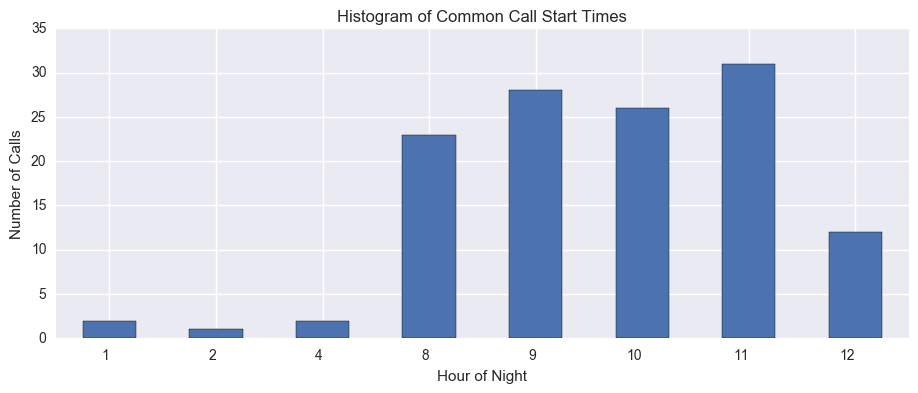

In [32]:
#plot
fig = plt.figure()
times.groupby(times.dt.hour).count().plot(kind="bar",figsize=(11,4),title='Histogram of Common Call Start Times')
plt.gca().set_xlabel("Hour of Night")
plt.xticks(rotation=0, ha='right')
plt.gca().set_ylabel("Number of Calls")
plt.show()
fig.savefig("callStarts.png")

From this plot we can see that the hours of 2 and 4 are probably errors that crept through, but otherwise it looks like the most popular call time is 11pm, followed by 9pm. There are far fewer calls at or after 12, the end of our night, as compared to 8, right at the start, which might say something about our hours. We would need more data and more thorough analysis to be completely sure.

## Counting Common Terms
We can try and count the common terms in the call logs; it might give us an idea of the topics that come up in our calls.

Let's see what all the call content has looked like.

In [33]:
# we use stopwords to reduce the probability of getting
# filler words and words that are just used for communicative
# clarity; we also add any anomalies or that come up, 
# such as "call" and "caller";
# we also want to remove names and numbers from the
# count, so we use the list of names we produced earlier

individualNames = []
for i in range(len(allnames)):
    current = allnames[i].split()
    for j in range(len(current)):
        individualNames.append(current[j].lower())
        
stops = [word for word in stopwords.words('english')
        ]+["call", "caller", ">", ">>", "", "email", "primary", "secondary",
          "number", "like", "student", "said", "asked", "vp", "schedule",
           "communications", "tonight", "got", "also", "center", "lot",
           "phone", "would", "hi", "facesforpeace", "http", "president",
           "mail", "etc", "gmail", "hello", "start", "end", "description",
           "skills", "iphone", "counselor", "jess", "vicki", "get", "go",
           "hey", "hi"
          ]+[word for word in individualNames
            ]+[str(i) for i in range(0,10000)
              ]+[str(i)+"pm" for i in range(0,60)
                ]+["0"+str(i) for i in range(0,10)
                  ]+[string.ascii_lowercase[i] for i in range(len(list(string.ascii_lowercase)))]

stops = [WordNetLemmatizer().lemmatize(t) for t in stops]
stops = [PorterStemmer().stem(t) for t in stops]

corpus = []
for i in calls.itertuples():
    emailBody=i[3]
    emailBody = re.split('\W+', emailBody)
    emailBody = [WordNetLemmatizer().lemmatize(word) for word in emailBody]
    emailBody = [PorterStemmer().stem(word) for word in emailBody]
    corpus = corpus + [word for word in emailBody if word not in stops]
    
wordcount = Counter(corpus).most_common()

Below we can see the top 50 words that come out of our call logs:

In [34]:
print(str(len(wordcount)) + " common words.")
print(wordcount[:50])

2160 common words.
[('feel', 444), ('talk', 354), ('want', 230), ('time', 226), ('use', 200), ('friend', 185), ('felt', 161), ('valid', 157), ('tri', 151), ('back', 128), ('help', 126), ('realli', 118), ('question', 117), ('say', 115), ('seem', 115), ('recommend', 114), ('problem', 111), ('mention', 104), ('could', 104), ('thought', 104), ('open', 96), ('think', 89), ('situat', 87), ('last', 87), ('make', 84), ('one', 84), ('know', 81), ('need', 78), ('summar', 77), ('told', 76), ('thank', 76), ('minut', 75), ('thing', 75), ('state', 72), ('reflect', 72), ('issu', 71), ('relationship', 71), ('work', 68), ('good', 67), ('first', 65), ('ye', 63), ('new', 62), ('normal', 60), ('take', 59), ('life', 58), ('sinc', 58), ('continu', 57), ('around', 57), ('school', 56), ('well', 55)]


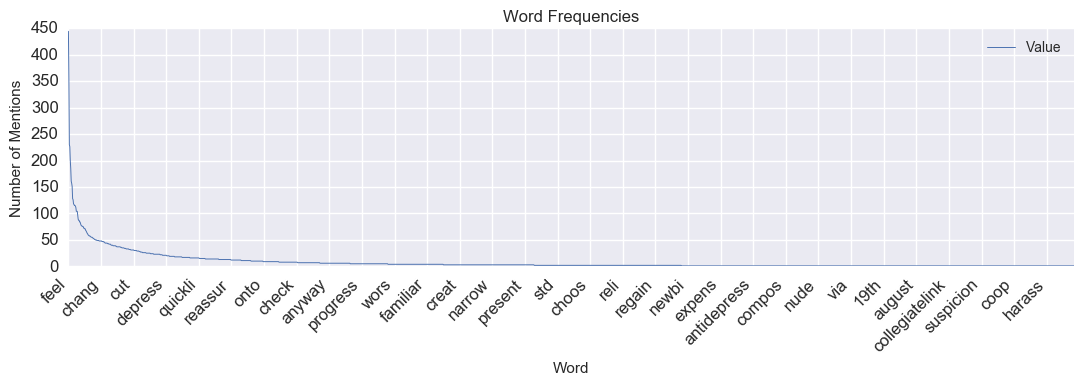

In [35]:
#plot
df = pd.DataFrame(wordcount)
df = df.rename(index=str, columns={0:"Word", 1:"Value"})
df = df.set_index("Word")
fig = plt.figure()
df.plot(figsize=(11,4), title='Word Frequencies', linewidth=0.7, fontsize = 12)
start, end = plt.gca().get_xlim()
step = 70
labels = df["Value"][::step].index
plt.xticks(range(int(start), int(end), step), labels, rotation=45, ha='right')
plt.gca().set_ylabel("Number of Mentions")
plt.tight_layout()
plt.show()
fig.savefig("wordFreq.png")

This is good, but we may be able to get more from observing a few words at a time since we can't possibly fill 3000 different words on a single axis (our data-ink ratio is low).

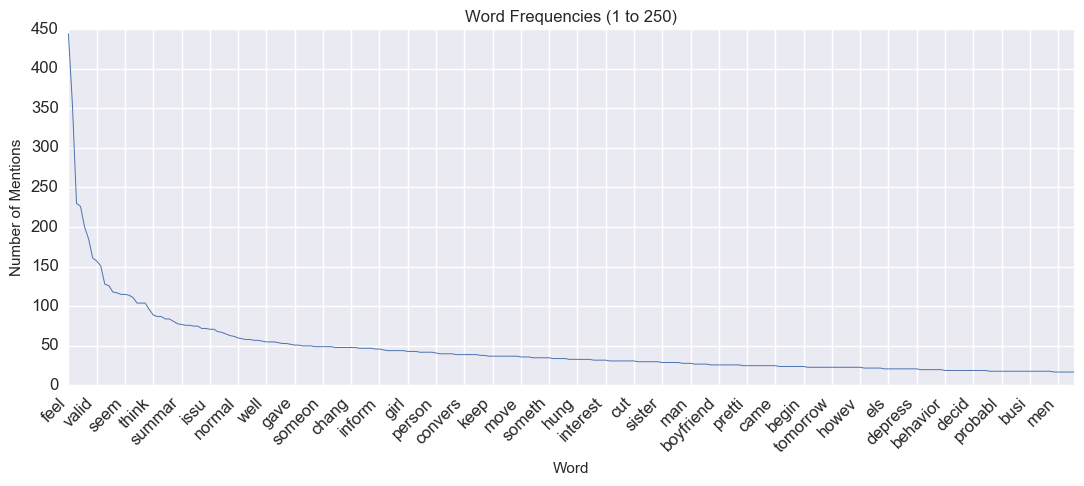

In [36]:
#plot
fig = plt.figure()
df = pd.DataFrame(wordcount)
df = df.rename(index=str, columns={0:"Word", 1:"Value"})
df = df.set_index("Word")
df["Value"][:250].plot(figsize=(11,5),title='Word Frequencies (1 to 250)', linewidth=0.7, fontsize = 12)
start, end = plt.gca().get_xlim()
step = 7
labels = df["Value"][::step].index
plt.xticks(range(int(start), int(end), step), labels, rotation=45, ha='right')
plt.gca().set_ylabel("Number of Mentions")
plt.tight_layout()
plt.show()
fig.savefig("wordFreq_250.png")

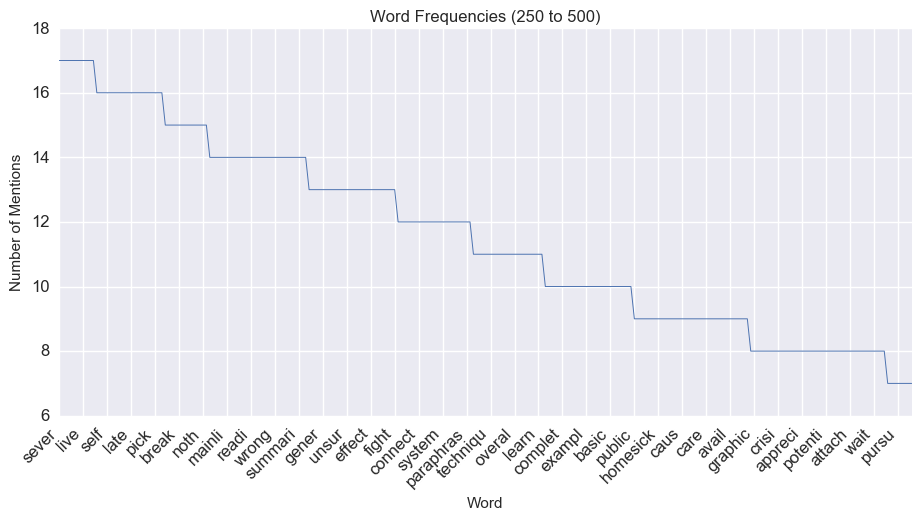

In [37]:
#plot
fig = plt.figure()
df = pd.DataFrame(wordcount)
df = df.rename(index=str, columns={0:"Word", 1:"Value"})
df = df.set_index("Word")
df["Value"][250:500].plot(figsize=(11,5),title='Word Frequencies (250 to 500)', linewidth=0.7, fontsize = 12)
start, end = plt.gca().get_xlim()
step = 7
labels = df["Value"][250:500:step].index
plt.xticks(range(int(start), int(end), step), labels, rotation=45, ha='right')
plt.gca().set_ylabel("Number of Mentions")
plt.show()
fig.savefig("wordFreq_500.png")

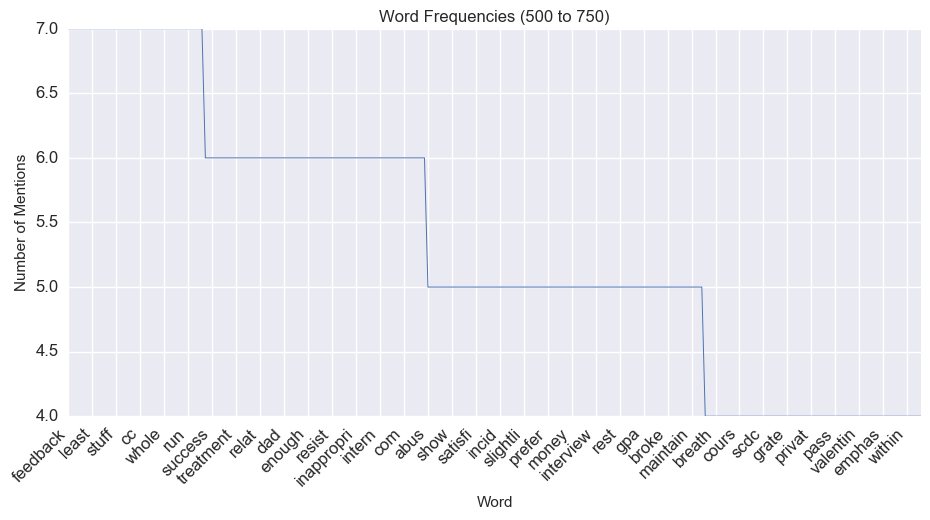

In [38]:
#plot
fig = plt.figure()
df = pd.DataFrame(wordcount)
df = df.rename(index=str, columns={0:"Word", 1:"Value"})
df = df.set_index("Word")
df["Value"][500:750].plot(figsize=(11,5),title='Word Frequencies (500 to 750)', linewidth=0.7, fontsize = 12)
start, end = plt.gca().get_xlim()
step = 7
labels = df["Value"][500:750:step].index
plt.xticks(range(int(start), int(end), step), labels, rotation=45, ha='right')
plt.gca().set_ylabel("Number of Mentions")
plt.show()
fig.savefig("wordFreq_750.png")

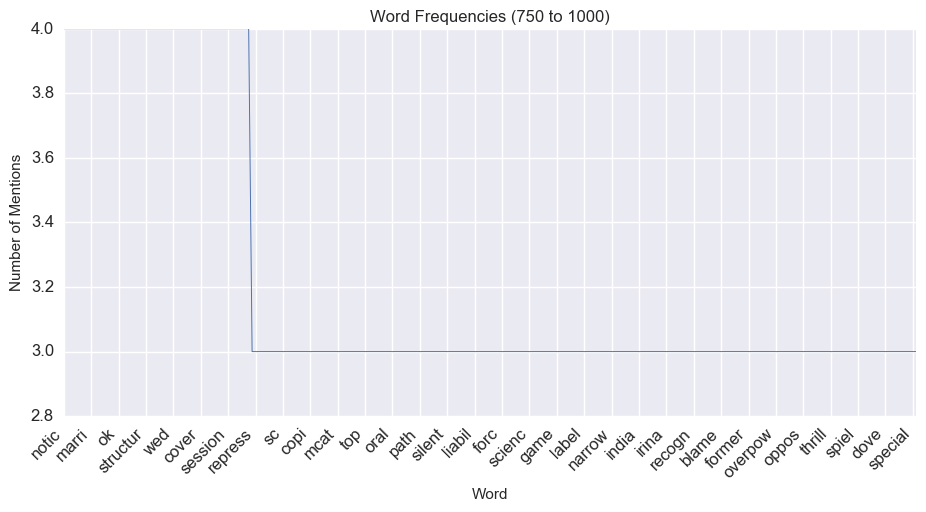

In [39]:
#plot
fig = plt.figure()
df = pd.DataFrame(wordcount)
df = df.rename(index=str, columns={0:"Word", 1:"Value"})
df = df.set_index("Word")
df["Value"][750:1000].plot(figsize=(11,5),title='Word Frequencies (750 to 1000)', linewidth=0.7, fontsize = 12)
start, end = plt.gca().get_xlim()
step = 8
labels = df["Value"][750:1000:step].index
plt.xticks(range(int(start), int(end), step), labels, rotation=45, ha='right')
plt.gca().set_ylabel("Number of Mentions")
plt.show()
fig.savefig("wordFreq_1000.png")

The *X*-axis doesn't have room for every word but showing every *n*th is still pretty good for visualisation. This is also quite interesting as we can see some of the common words we use in our call logs; it's encouraging to see that "feelings" is something we discuss most often.

We can approach this more computationally though: There is a handy statistical learning approach called Latent Dirichlet Allocation, which uses matrix factorisation to find topics in corpuses of words. It's a little bit like the word counter approach, but the algorithm is more thorough. It's relatively simple to implement and demonstrates machine learning in a very applicable and familiar context: the cognitive ability of human beings to read text and classify its relation to other texts, based on word frequencies and co-occurences.

Let's try to apply it to this corpus.

# LDA Topic Model on Email Call Logs

In [40]:
corpus = []
for i in calls.itertuples():
    emailBody=i[3]
    emailBody = re.split('\W+', emailBody)
    emailBody = [WordNetLemmatizer().lemmatize(word) for word in emailBody]
    emailBody = [PorterStemmer().stem(word) for word in emailBody]
    corpus.append([word for word in emailBody if word not in stops])

In [41]:
dictionary = gensim.corpora.Dictionary(corpus)
corpusMatrix = [dictionary.doc2bow(text) for text in corpus]
Lda = gensim.models.ldamodel.LdaModel
model = Lda(corpusMatrix, num_topics=10, id2word = dictionary, passes=100)

In [42]:
p = model.top_topics(corpusMatrix)
topics = pd.DataFrame(columns=['Weight','Word','Topic'])
for i in range(len(p)):
    for j in range(len(p[i][0])):
        line = p[i][0][j]
        update = {"Weight":line[0], "Word":line[1], "Topic":string.ascii_uppercase[i]}
        topics = topics.append(update, ignore_index=True)
topics["Weight"] = round(topics["Weight"],3).fillna(0)
topics.head()

,Weight,Word,Topic
0,0.032,feel,A
1,0.022,talk,A
2,0.016,friend,A
3,0.014,want,A
4,0.013,felt,A


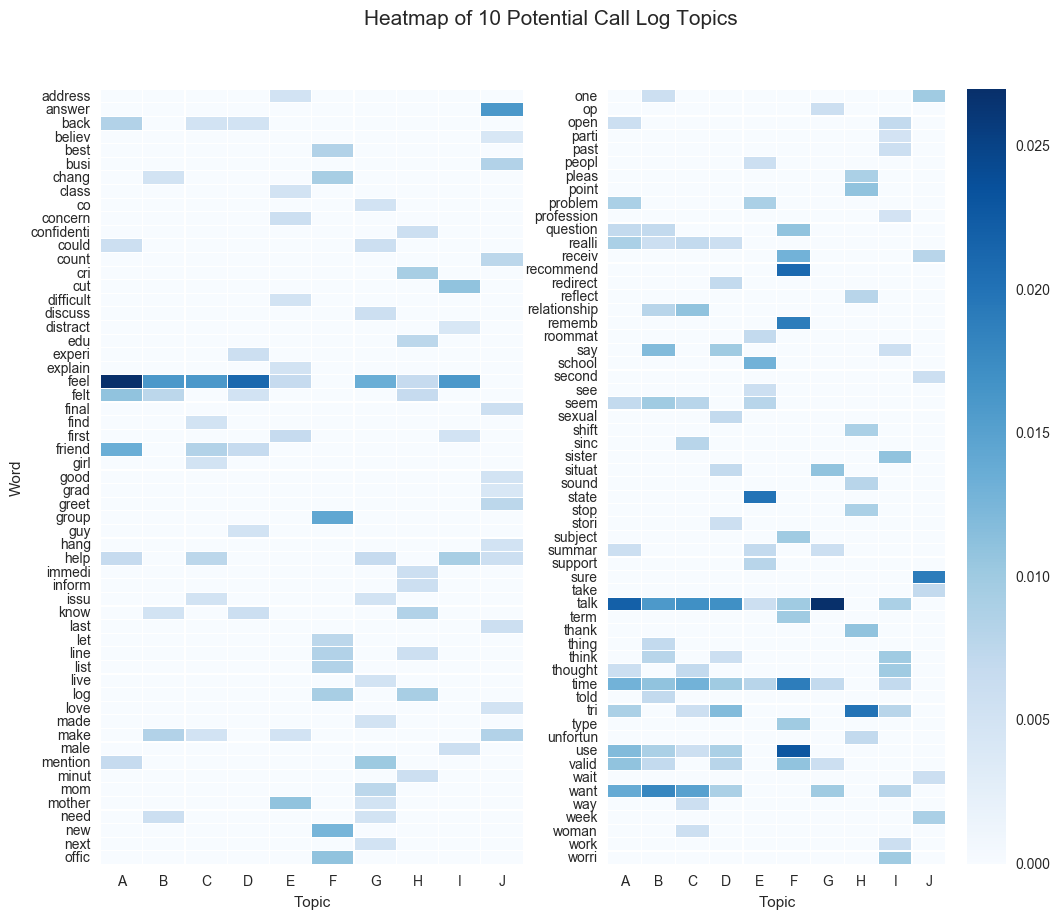

In [43]:
#plot
pTopics = topics.pivot(index="Word", columns='Topic', values='Weight').fillna(0)
g = int(len(pTopics)/2)
fig, ax = plt.subplots(2,figsize=(12,10), sharex=True, sharey=True)
plt.suptitle('Heatmap of 10 Potential Call Log Topics', fontsize=15)
plt.subplot(121)
sns.heatmap(pTopics[:g],linewidths=.1, cmap ="Blues", cbar=False)
plt.subplot(122)
sns.heatmap(pTopics[g:],linewidths=.1, cmap ="Blues")
plt.ylabel("")
plt.show()
fig.savefig("heatmap.png")

The LDA algorithm requires that the researcher provide the number of topics to model the data into; I've selected 10 for the convenience of visualisation and simplicity.

The first thing to notice is that **feel**, **felt**, and **talk**, are all weighed very highly in most topics. This is expected, but notice topic F instead weighs words like **change**, **use**, **remember**, **office**, and **line**. These are definitely admin emails that crept through the call logs (you can tell because it doesn't weigh any skill words); additionally, topic J may be an amalgamation of any non-call logs, as it correlates with a number of atypical words like **make**, **sure**, **week**, **take**, etc.

Topic A weighs **feel**, **want**, **talk**, and **help** highly. Additionally, it also wieighs **friend** and **problem**. I'd say that this might be a general call involving friendships. Topic B also resembles a typical call, but includes the word **relationship** highly weighted. 

Topic C weighs similarly to topic A, but includes the words **girl**, **woman**, and **relationship** very strongly. This suggests the common theme of relationship difficulties amongst the male callers (or generally those interested in women). 

Topic D is interesting; it emphasises **guy, friend, experience, story, situation,** and **sexual**. This would be a confusing one if we had not started noting down *the creeper* calls. This type of call is a lot rarer today, but distinct enough to stick out as one of our top ten topics. It's no surprise that the topic also weighs **redirect**.

Topic E seems to contain a hodgepodge of keywords, including **mother, support, school, roommate, difficult, class,** and **concern**. This might represent a significantly difficult call for the caller and the counselor (it also includes **time** quite strongly), but appears to be best handled with **summarisations**.

Topic G again weighs **feel** and **talk** quite highly, but also mentions **mother**, and **mom**. This type of call probably centers around the caller's relationship with their mother, but it's significant enough that mother sticks out on its own.

Topic H weighs **immediate, cry, try,** and **thank** highly. Additionally, it also takes into account **reflect**, which sugggests that cryers are best tackled with reflections.

In topic I, the first thing to notice is the word **male**; this word is accompanied by **profession** and **work**, as well as **sister** and **distract**. This might be evidence of another typical male caller's subject matter.

LDA is an interpretable algorithm that helps in defining components of a text-based dataset that are distinct and repetitive in observations. In other words, it finds the components of the text that significantly make it different from other texts. However, as an unsupervised learning algorithm, it is not very stable and can be sensitive to small changes, meaning that this data 

# Active Listening Skills

Something that important to us as PCs is using our active listening skills. We can count how many times our active listening skills are mentioned in the call logs, to see which ones come up most frequently.

In [44]:
skills = ["rapport", "empathy", "genuineness", "encouragers",
          "validation", "normalization", "reflection", "content",
          "paraphrasing", "summarization", "redirection", "advice", "question",
          "open-ended", "closed-ended", "problem-solving", "brainstorming",
          "silence"]

skills = [WordNetLemmatizer().lemmatize(t) for t in skills]
skills = [PorterStemmer().stem(word) for word in skills]

print("Active listening skills taken from the manual:\n\n" + str(skills))

Active listening skills taken from the manual:

['rapport', 'empathi', 'genuin', 'encourag', 'valid', 'normal', 'reflect', 'content', 'paraphras', 'summar', 'redirect', 'advic', 'question', 'open-end', 'closed-end', 'problem-solv', 'brainstorm', 'silenc']


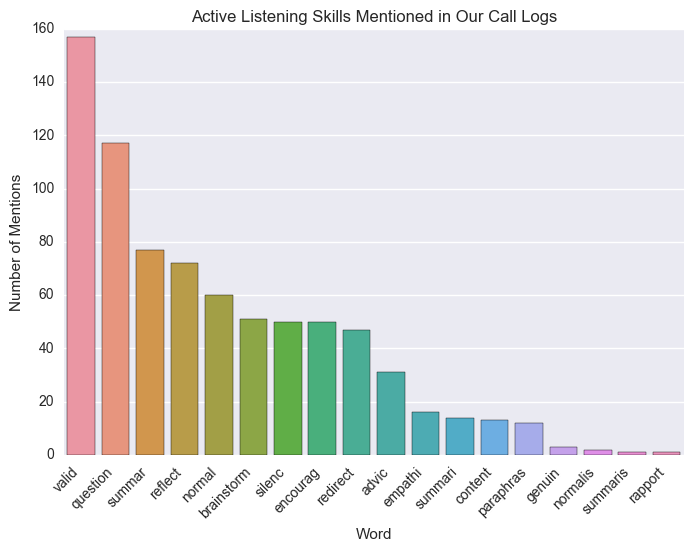

In [45]:
active_listening=[]
for i in range(len(skills)):
    for j in range(len(wordcount)):
        if skills[i] in wordcount[j][0]:
            active_listening.append(wordcount[j])

#plot
fig = plt.figure()
df = pd.DataFrame(active_listening)
df = df.rename(index=str, columns={0:"Word", 1:"Value"})
df = df.sort_values("Value", ascending=False)
sns.barplot(x="Word", y="Value", data=df)
sns.plt.title("Active Listening Skills Mentioned in Our Call Logs")
plt.xticks(rotation=45, ha='right')
plt.ylabel('Number of Mentions')
plt.show()
fig.savefig("skills.png")

This is awesome. It looks like **validations** are the most commonly used and mentioned skill in our call logs, followed by **questions**, **summarisations**, and **reflection**. Reflections might be a bit ambiguous though, because it could contain both content and feeling. "Feelings" can be in the appearance of conflicting meaning in sentences, namely the skill "reflection of feeling", and the redirection attempt resulting in the term, "focus on feelings", so we left that word out as well.

# Summary

In this analysis, we used Gmail's "takeout" option to get emails from the Peer Counseling Helpline's (now obsolete) email address into a database that we can analyse programmatically in Python. We used Pandas to build dataframes of these emails, matplotlib and Seaborn to plot the data, and basic statistics to find out some interesting facts about the helpline and how it has run over the past years. We also used lemmatisation to run a simple natural language analysis on the material in the call logs, as well as Latent Dirichlet Allocation to distinguish topics algorithmically.

We found out that:

1. Winter Term is our busiest term for admin.
2. Spring Term is our busiest term for calls.
3. Monday night is our most popular night for calls, followed by Thursday. Sunday is our least popular, which may have something to do with the weekend.
4. We usually have 25 active counselors in a term, but it can go to as little as 16.
5. Winter Term is our term with the most counselors; there was an outlier one spring where we had 38 counselors after recruitment!
6. Our calls come in most often between 11pm and midnight, and then beween 9pm and 10pm. Surprisingly, we have the fewest calls after 12.
7. Our calls can be quite diverse. Callers mention relationships, friends, excercise, failure, mothers, stress, "encounters" (most definitely the infamous *creeper* repeat caller), acceptance, loneliness, depression, homesickness, and many more. Like we're trained to do, we tend to talk about feelings a lot.
8. We used LDA to find topics in our call logs. The most discernable ones were: 
  * Friendships
  * Relationships
  * Creepy calls (sexual topics; best handled with redirections)
  * Everything and the kitchen sink (lots of topics; best handled with summarisations)
  * Moms!
  * Weepy calls (usually dealt with by using reflections)
  * Work-life (usually males; incidentally, male callers mention their sisters often too!)
9. The most effective and commonly used skills that our counselors implement in the calls are validations, questions, summarisations, and reflections.

## Blogs and Pages I Need to Thank (i.e. copy/pasted code from)

* https://mail.python.org/pipermail/tutor/2008-September/064272.html
* https://pymotw.com/2/mailbox/
* http://stackoverflow.com/questions/4824376/parse-multi-part-email-with-sub-parts-using-python
* http://geoffboeing.com/2016/02/visualizing-gmail-inbox/
* http://www.jamesphoughton.com/2016/02/06/Email-Data-Formatter.html
* http://engineroom.trackmaven.com/blog/monthly-challenge-natural-language-processing/
* https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/
* http://chrisalbon.com/